In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [123]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

In [124]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [125]:
df['Date']=df.index

In [126]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [127]:
df=df.loc[mask]

In [128]:
df=df.loc[mask]

In [129]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [130]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [131]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [132]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [133]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [134]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [135]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 400)          323200    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 50, 400)          961600    
 onal)                                                           
                                                                 
 global_max_pooling1d_6 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 100)               40100     
                                                           

In [136]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [137]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [138]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
53/53 [==============================] - 46s 715ms/step - loss: 109.1611 - mae: 7.2886 - mse: 109.1611 - val_loss: 1001.7778 - val_mae: 20.4630 - val_mse: 1001.7778
Epoch 2/100
53/53 [==============================] - 35s 660ms/step - loss: 108.6790 - mae: 7.2778 - mse: 108.6790 - val_loss: 1003.2513 - val_mae: 20.4002 - val_mse: 1003.2513
Epoch 3/100
53/53 [==============================] - 36s 675ms/step - loss: 108.4913 - mae: 7.2621 - mse: 108.4913 - val_loss: 1003.5031 - val_mae: 20.4027 - val_mse: 1003.5031
Epoch 4/100
53/53 [==============================] - 34s 646ms/step - loss: 108.6282 - mae: 7.2630 - mse: 108.6282 - val_loss: 1004.4008 - val_mae: 20.4054 - val_mse: 1004.4008
Epoch 5/100
53/53 [==============================] - 36s 672ms/step - loss: 108.3821 - mae: 7.2657 - mse: 108.3821 - val_loss: 1003.0877 - val_mae: 20.4107 - val_mse: 1003.0877
Epoch 6/100
53/53 [==============================] - 36s 672ms/step - loss: 108.4625 - mae: 7.2601 - mse: 108.4625 

Bi-directional GRU

In [139]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_7 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_21 (Dense)            (None, 100)               40100     
                                                           

In [140]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [141]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [142]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
53/53 [==============================] - 39s 576ms/step - loss: 109.6723 - mae: 7.3030 - mse: 109.6723 - val_loss: 1002.1382 - val_mae: 20.4683 - val_mse: 1002.1382
Epoch 2/100
53/53 [==============================] - 28s 537ms/step - loss: 108.7349 - mae: 7.2779 - mse: 108.7349 - val_loss: 1004.0135 - val_mae: 20.3832 - val_mse: 1004.0135
Epoch 3/100
53/53 [==============================] - 29s 555ms/step - loss: 108.4740 - mae: 7.2638 - mse: 108.4740 - val_loss: 1004.5550 - val_mae: 20.3845 - val_mse: 1004.5550
Epoch 4/100
53/53 [==============================] - 29s 551ms/step - loss: 108.7270 - mae: 7.2655 - mse: 108.7270 - val_loss: 1005.3510 - val_mae: 20.3960 - val_mse: 1005.3510
Epoch 5/100
53/53 [==============================] - 29s 549ms/step - loss: 108.4054 - mae: 7.2734 - mse: 108.4054 - val_loss: 1003.7714 - val_mae: 20.3932 - val_mse: 1003.7714
Epoch 6/100
53/53 [==============================] - 28s 527ms/step - loss: 108.3995 - mae: 7.2592 - mse: 108.3995 

Predictions

In [143]:
train_idx[:T+1]=False

In [144]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [145]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [146]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [147]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [148]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [149]:
last_train=train.iloc[-1]['Prev Close']

In [150]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [151]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

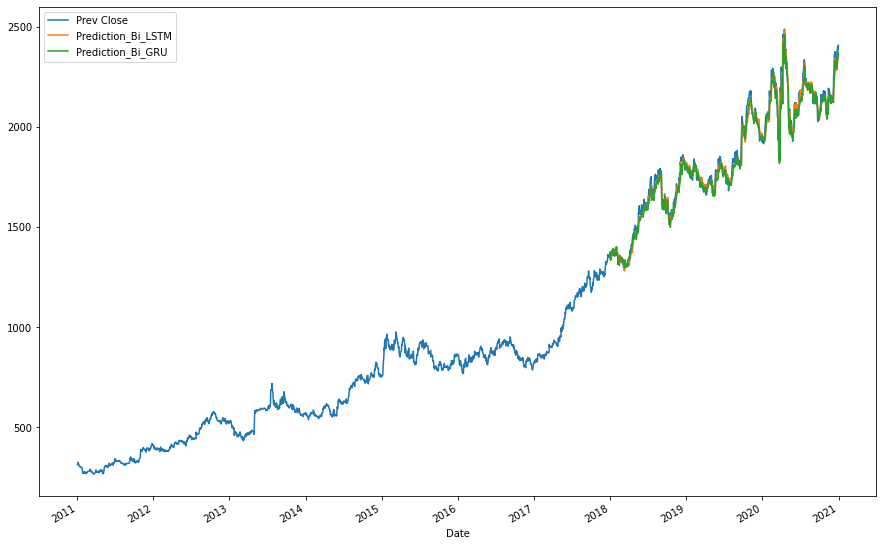

In [152]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

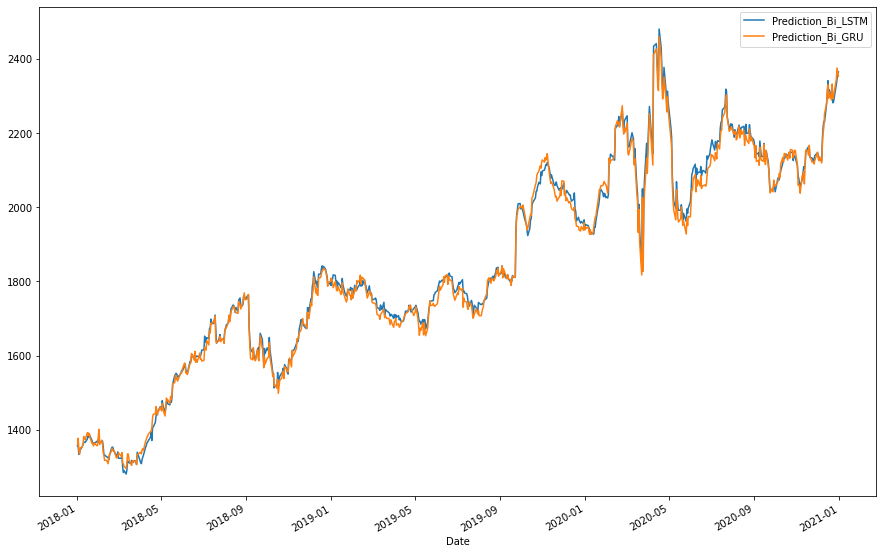

In [153]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [154]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [155]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

39.38923436678554


In [156]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

28.299290904522053


In [157]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.9802115626973855

In [158]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [159]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

40.709034908480675


In [160]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

28.787538593269453


In [161]:
r2_score(test['Prev Close'],pred_bi_gru)

0.9788632585972644